## EXPLORATION 14. 어제 오른 내 주식, 과연 내일은?

### 0. 함수 정의

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')

    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def plot_rolling_statistics(timeseries, window=12):

    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def nan_del(data): # 결측치 처리
    data=data.interpolate(method='time')
    data[data.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
    return data

def visual1(ts_log,trend,seasonal,resiual):
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

def train_test_split(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data,test_data

def visual2(ts_log):
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

def difference(ts_log):
    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)

    # 혹시 필요한 경우 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)
    return diff_1, diff_2

def modelfit(train_data,p=1,d=1,q=0):
    # Build Model
    model = ARIMA(train_data, order=(p, d, q))
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())
    return fitted_m

def model_test(fitted_m,test_data):
    # Forecast : 결과가 fc에 담깁니다.
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    return fc,se,conf

def last_prediction_MAPE(test_data,fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

def time_series_stability(ts_log):
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

    #시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    return trend,seasonal,residual

### 1. 시계열 데이터 준비

In [72]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### 2. 전처리 수행

In [73]:
# 결측치 처리
ts = nan_del(ts)

# 로그 변환 시도
ts_log = np.log(ts)

### 3. 시계열 안정성 분석

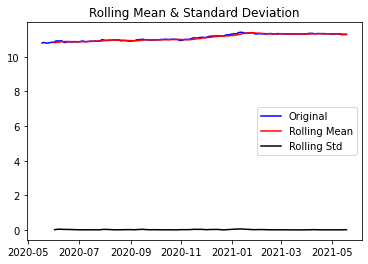

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


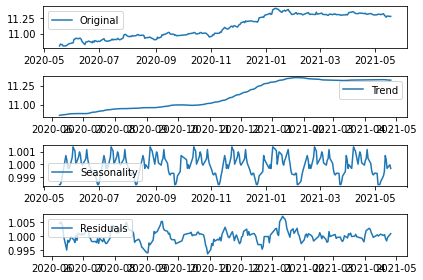

In [84]:
trend,seasonal,residual = time_series_stability(ts_log)
# 정성적 그래프 분석,정량적 Augmented Dicky-Fuller Test, 시계열 분해

visual1(ts_log,trend,seasonal,residual) # Residual 안정성 확인

In [76]:
residual.dropna(inplace=True) # Residual 안정성 확인
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### 4. 학습,테스트 데이터셋 생성

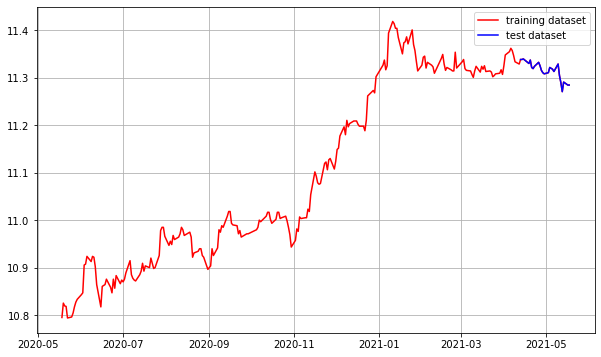

In [77]:
train_data,test_data = train_test_split(ts_log)

### 5. 적정 ARIMA 모수 찾기

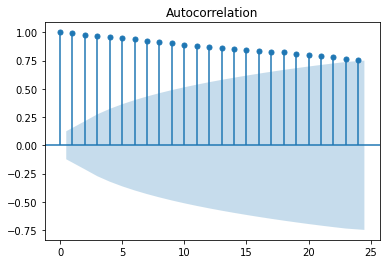

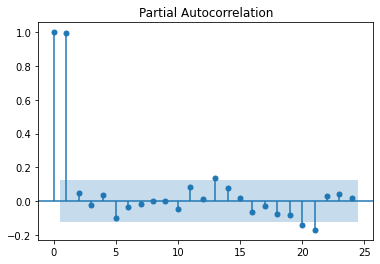

In [78]:
visual2(ts_log) #ACF,PACF 그려보기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


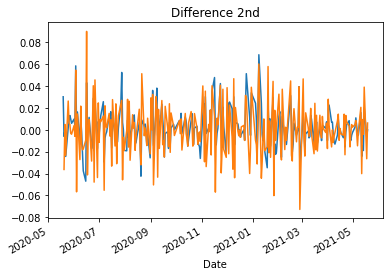

In [79]:
diff_1,diff_2 = difference(ts_log) # 차분 안정성 확인

### 6. ARIMA 모델 훈련과 테스트

In [80]:
fitted_m = modelfit(train_data) # ARIMA 모델 빌드와 훈련, 기본값 p=1,d=1,q=0

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 16 Nov 2021   AIC                          -1164.792
Time:                        19:01:58   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

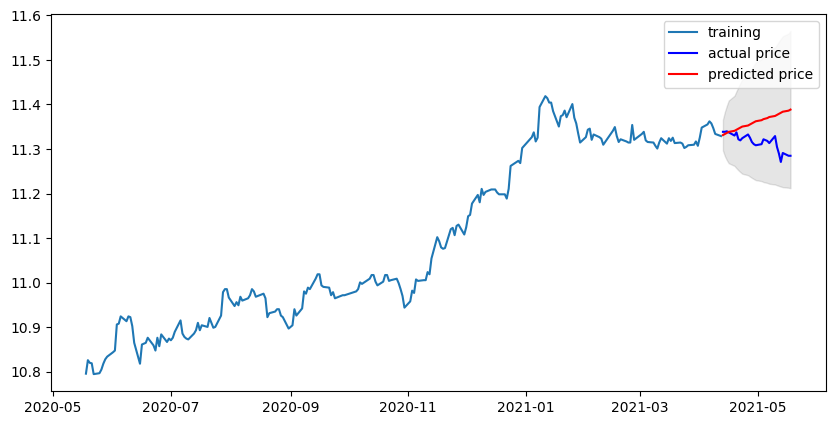

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


In [81]:
fc,se,conf = model_test(fitted_m,test_data) # 모델 테스트 및 플로팅
last_prediction_MAPE(test_data,fc) # 최종 예측 모델 정확도 측정

### 7. 다른 주식 종목 예측해 보기 with Tesla , Apple, Nvidia

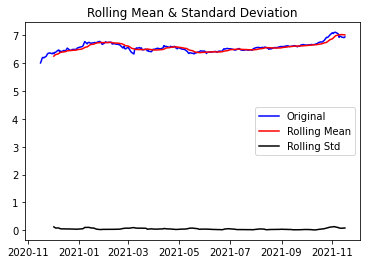

Results of Dickey-Fuller Test:
Test Statistic                  -2.547210
p-value                          0.104406
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.568091
p-value                          0.000001
#Lags Used                       9.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


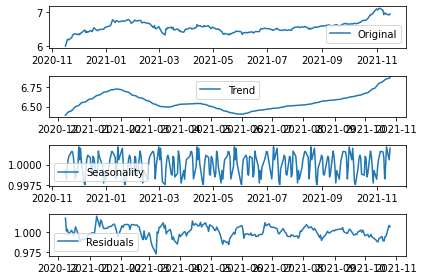

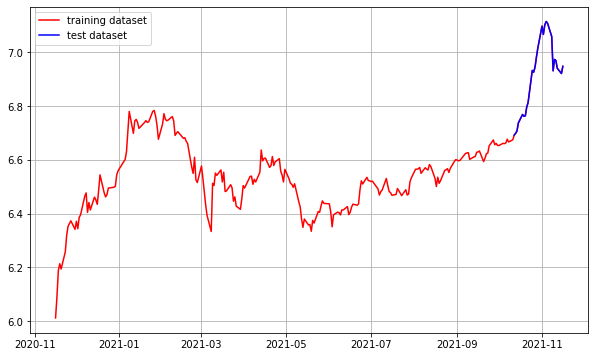

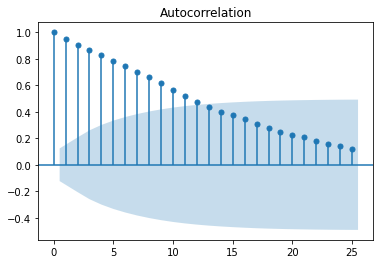

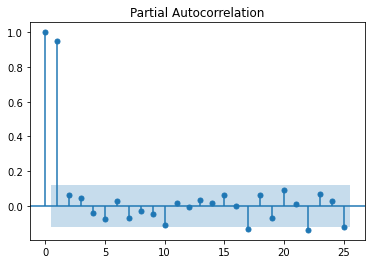

Results of Dickey-Fuller Test:
Test Statistic                -1.648919e+01
p-value                        2.200448e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.103055e+00
p-value                        4.120316e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(3, 2, 2)   Log Likelihood                 440.859
Method:                       css-mle   S.D. of innovations              0.034
Date:                Tue, 16 Nov 2021   AIC                           -867.718
Time:                        19:14:42   BIC                           -843.805
Sample:                             2   HQIC                          -858.067
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -4.32e-05   3.13e-05     -1.379      0.168      -0.000    1.82e-05
ar.L1.D2.Close    -0.6070        nan        nan        nan         nan         nan
ar.L2.D2.Close    -0.0645      0.074

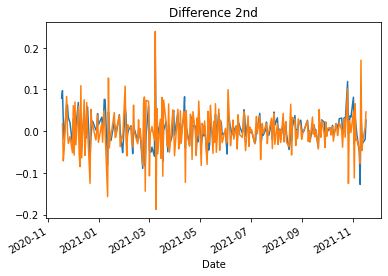

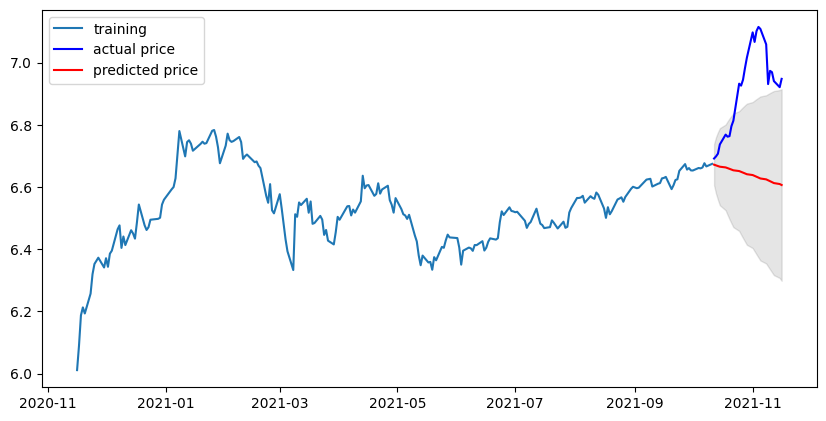

MSE:  83632.4201438988
MAE:  249.3712657382048
RMSE:  289.1927041678244
MAPE: 23.01%


In [99]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 결측치 처리
ts = nan_del(ts)

# 로그 변환 시도
ts_log = np.log(ts)

# 3. 시계열 안정성 분석

trend,seasonal,residual = time_series_stability(ts_log)
# 정성적 그래프 분석,정량적 Augmented Dicky-Fuller Test, 시계열 분해

visual1(ts_log,trend,seasonal,residual) # Residual 안정성 확인

residual.dropna(inplace=True) # Residual 안정성 확인
augmented_dickey_fuller_test(residual)


# 4. 학습,테스트 데이터셋 생성
train_data,test_data = train_test_split(ts_log)


# 5. 적정 ARIMA 모수 찾기
visual2(ts_log) #ACF,PACF 그려보기

diff_1,diff_2 = difference(ts_log) # 차분 안정성 확인

# 6. ARIMA 모델 훈련과 테스트

fitted_m = modelfit(train_data,3,2,2) # ARIMA 모델 빌드와 훈련, 기본값 p=1,d=1,q=0

fc,se,conf = model_test(fitted_m,test_data) # 모델 테스트 및 플로팅
last_prediction_MAPE(test_data,fc) # 최종 예측 모델 정확도 측정

- p=1,d=1,q=0 -> MAPE: 17.59%
- p=1,d=2,q=0 -> MAPE: 22.45%
- p=2,d=0,q=0 -> MAPE: 22.76%
- p=3,d=0,q=0 -> MAPE: 22.69%
- p=3,d=1,q=0 -> MAPE: 17.53%
- p=3,d=1,q=3 -> MAPE: 17.03%

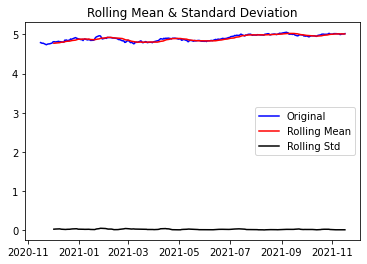

Results of Dickey-Fuller Test:
Test Statistic                  -1.570119
p-value                          0.498584
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.355757
p-value                          0.000004
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


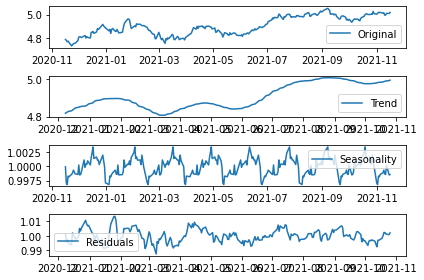

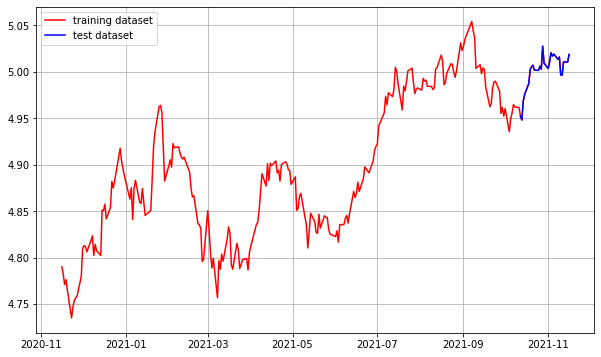

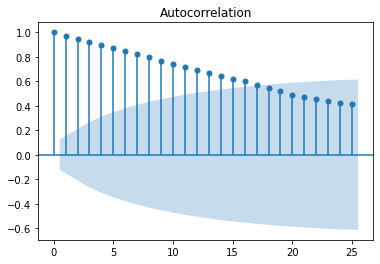

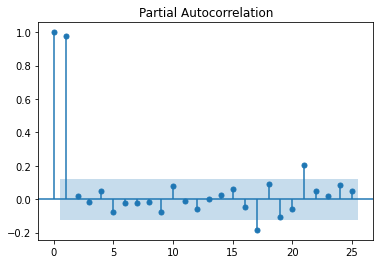

Results of Dickey-Fuller Test:
Test Statistic                -1.655596e+01
p-value                        1.926249e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.589017e+00
p-value                        2.560793e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 561.386
Method:                       css-mle   S.D. of innovat

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

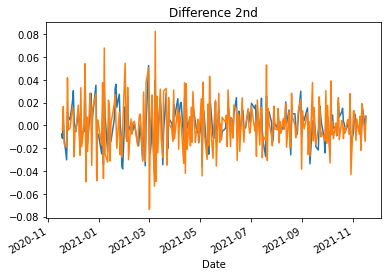

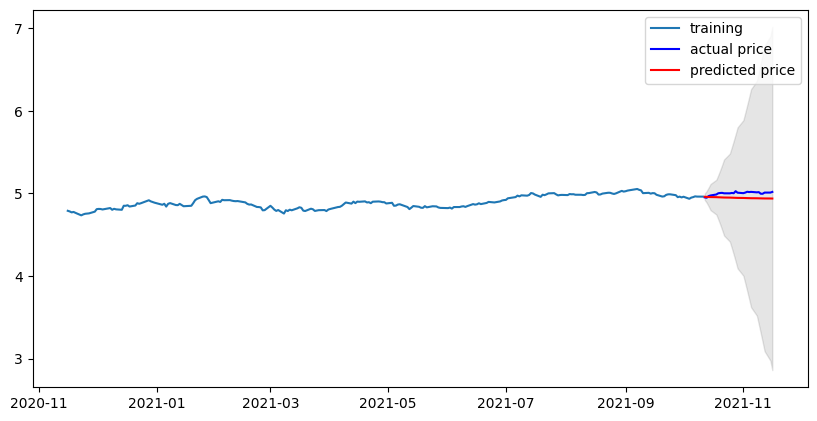

MSE:  73.3349675090541
MAE:  7.9664569418087074
RMSE:  8.563583800550683
MAPE: 5.32%


In [102]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 결측치 처리
ts = nan_del(ts)

# 로그 변환 시도
ts_log = np.log(ts)

# 3. 시계열 안정성 분석

trend,seasonal,residual = time_series_stability(ts_log)
# 정성적 그래프 분석,정량적 Augmented Dicky-Fuller Test, 시계열 분해

visual1(ts_log,trend,seasonal,residual) # Residual 안정성 확인

residual.dropna(inplace=True) # Residual 안정성 확인
augmented_dickey_fuller_test(residual)


# 4. 학습,테스트 데이터셋 생성
train_data,test_data = train_test_split(ts_log)


# 5. 적정 ARIMA 모수 찾기
visual2(ts_log) #ACF,PACF 그려보기

diff_1,diff_2 = difference(ts_log) # 차분 안정성 확인

# 6. ARIMA 모델 훈련과 테스트

fitted_m = modelfit(train_data,1,2,0) # ARIMA 모델 빌드와 훈련, 기본값 p=1,d=1,q=0

fc,se,conf = model_test(fitted_m,test_data) # 모델 테스트 및 플로팅
last_prediction_MAPE(test_data,fc) # 최종 예측 모델 정확도 측정

- p=1 d=1 q=0 -> MAPE: 3.07%
- p=1 d=2 q=0 -> MAPE: 5.32%
- p=1 d=2 q=2 -> MAPE: 3.92%

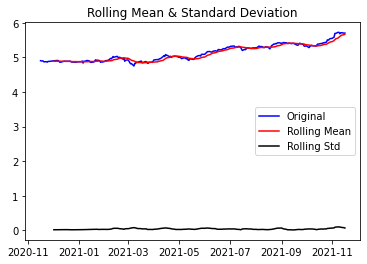

Results of Dickey-Fuller Test:
Test Statistic                   0.709827
p-value                          0.990032
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -4.647710
p-value                          0.000105
#Lags Used                       2.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


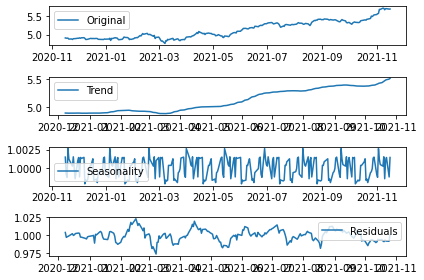

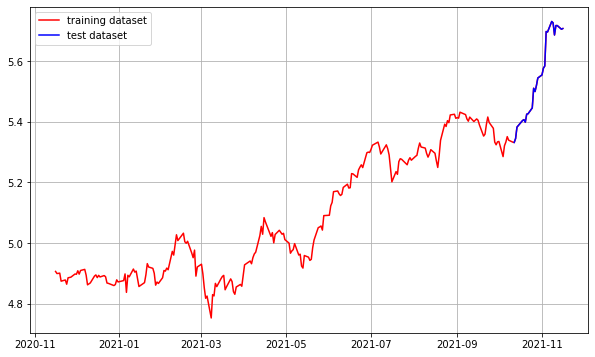

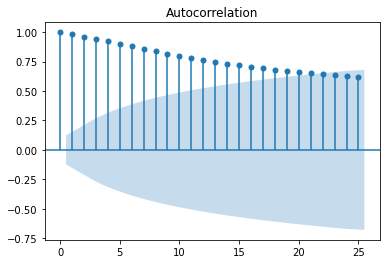

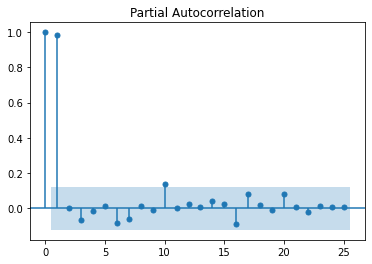

Results of Dickey-Fuller Test:
Test Statistic                -1.660996e+01
p-value                        1.734405e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.184872e+01
p-value                        7.294082e-22
#Lags Used                     5.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 4)   Log Likelihood                 517.775
Method:                       css-mle   S.D. of innovations              0.024
Date:                Tue, 16 Nov 2021   AIC                          -1021.551
Time:                        19:30:50   BIC                           -997.638
Sample:                             2   HQIC                         -1011.899
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8.797e-06   2.56e-05      0.344      0.731   -4.13e-05    5.89e-05
ar.L1.D2.Close    -0.6472      0.414     -1.562      0.118      -1.459       0.165
ma.L1.D2.Close    -0.3924      0.419

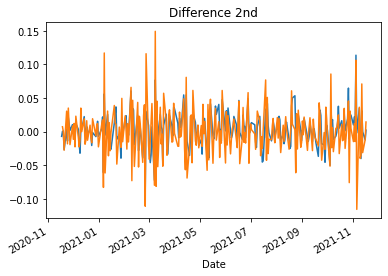

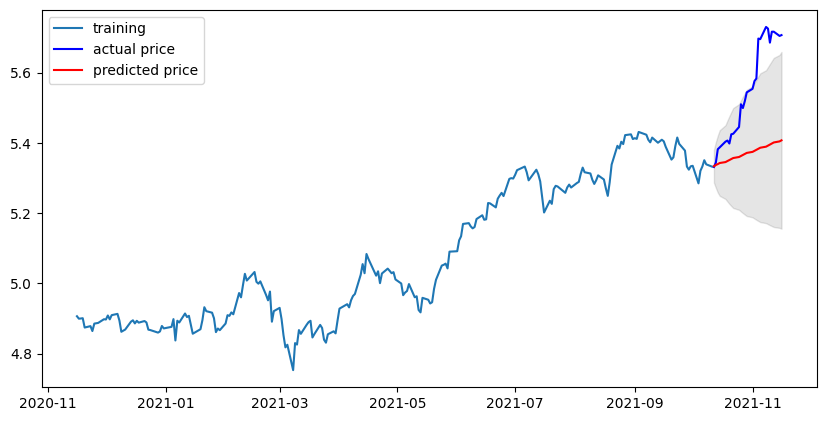

MSE:  2779.2060984200443
MAE:  42.86658751557541
RMSE:  52.71817616742867
MAPE: 15.31%


In [111]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVDA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 결측치 처리
ts = nan_del(ts)

# 로그 변환 시도
ts_log = np.log(ts)

# 3. 시계열 안정성 분석

trend,seasonal,residual = time_series_stability(ts_log)
# 정성적 그래프 분석,정량적 Augmented Dicky-Fuller Test, 시계열 분해

visual1(ts_log,trend,seasonal,residual) # Residual 안정성 확인

residual.dropna(inplace=True) # Residual 안정성 확인
augmented_dickey_fuller_test(residual)


# 4. 학습,테스트 데이터셋 생성
train_data,test_data = train_test_split(ts_log)


# 5. 적정 ARIMA 모수 찾기
visual2(ts_log) #ACF,PACF 그려보기

diff_1,diff_2 = difference(ts_log) # 차분 안정성 확인

# 6. ARIMA 모델 훈련과 테스트

fitted_m = modelfit(train_data,1,2,4) # ARIMA 모델 빌드와 훈련, 기본값 p=1,d=1,q=0

fc,se,conf = model_test(fitted_m,test_data) # 모델 테스트 및 플로팅
last_prediction_MAPE(test_data,fc) # 최종 예측 모델 정확도 측정

- p=1 d=1 q=1 -> MAPE: 16.33%
- p=1 d=1 q=0 -> MAPE: 16.24%
- p=1 d=1 q=2 -> MAPE: 16.38%
- p=1 d=2 q=2 -> MAPE: 15.38%
- p=1 d=2 q=4 -> MAPE: 15.31%

#### 회고
시계열의 p,d,q를 바꿔가면서 ARIMA에 예측 모델을 처음 경험 해봤는데 주식 예측 모델중에 ARIMA에 시계열 예측이 어떤 의미인지
알게 되었다. 전에 주식 데이터를 봇으로 만든 경험이 있었는데 시계열 에측 분석 모델도 적용해서 매수 ,매도 알고리즘을 잘 짜면
활용 방안이 넓을꺼라 생각했다.